# CLIP: Contrastive Language-Image Pretraining

This notebook implements a CLIP model from scratch and demonstrates training on the Flickr30k dataset.

Sections:
- Model architecture (Vision Transformer, Text Transformer)
- Dataset preparation (Flickr30k)
- Training loop
- Visualization and evaluation

In [12]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from typing import Tuple, Optional
import os
from PIL import Image
import random
from IPython.display import display

## Model Architecture

This section implements the CLIP model, including the Vision Transformer (ViT) for images and a Transformer for text.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int = 224, patch_size: int = 16, in_channels: int = 3, embed_dim: int = 768):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, stride=patch_size, kernel_size=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)  # x : (B, C, H, W) -> (B, E, H/P, W/P)
        x = x.flatten(2)  # x : (B, E, H/P, W/P) -> (B, E, N) where N = (H/P)*(W/P)
        x = x.transpose(1, 2)  # x : (B, E, N) -> (B, N, E)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int = 768, num_heads: int = 12, dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.qkv = nn.Linear(in_features=embed_dim, out_features=embed_dim*3)
        self.proj = nn.Linear(in_features=embed_dim, out_features=embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape # x : (B, N, C)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim) # qkv : (B, N, 3, num_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # qkv : (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0] , qkv[1], qkv[2] # each has shape (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn : (B, num_heads, N, N)
        attn = attn.softmax(dim=-1)  # attn : (B, num_heads, N, N)
        attn = self.dropout(attn)  # attn : (B, num_heads, N, N)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C) # x : (B, N, C)
        x = self.proj(x) # x : (B, N, C)
        x = self.dropout(x)  # x : (B, N, C)

        return x

class MLP(nn.Module):
    def __init__(self, embed_dim: int = 768, mlp_ratio: float = 4.0, dropout: float = 0.1):
        super(MLP, self).__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)  # x : (B, N, hidden_dim)
        x = self.act(x)  # x : (B, N, hidden_dim)
        x = self.dropout(x) # x : (B, N, hidden_dim)
        x = self.fc2(x)  # x : (B, N, embed_dim)
        x = self.dropout(x) # x : (B, N, embed_dim)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int = 768, num_heads: int = 12, mlp_ratio: float = 4.0, dropout: float = 0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio, dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x)) # Residual connection
        x = x + self.mlp(self.norm2(x)) # Residual connection
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        dropout: float = 0.1,
        output_dim: int = 512
    ):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        n_patches = self.patch_embed.n_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, dropout=dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.proj = nn.Linear(in_features=embed_dim, out_features=output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        x = self.patch_embed(x) # x : (B, N, E)
        cls_token = self.cls_token.expand(B, -1, -1) # cls_token : (B, 1, E)
        x = torch.cat([cls_token, x], dim=1)  # x : (B, N+1, E)
        x = x + self.pos_embed  # x : (B, N+1, E)
        x = self.dropout(x)  # x : (B, N+1, E)

        for block in self.blocks:
            x = block(x) # x : (B, N+1, E)
        x = self.norm(x)
        x = x[:, 0]  # x : (B, E)
        x = self.proj(x)  # x : (B, output_dim)
        return x


### Text Encoder - Transformer
Implements the text encoder for CLIP using a Transformer architecture.

In [14]:
class TextTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int = 49408,
        embed_dim: int = 512,
        max_len: int = 77,
        num_heads: int = 8,
        depth: int = 12,
        mlp_ratio: float = 4.0,
        dropout: float = 0.1,
        output_dim: int = 512
    ):
        super(TextTransformer, self).__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.token_embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, dropout=dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.proj = nn.Linear(in_features=embed_dim, out_features=output_dim)

    def forward(self, text: torch.Tensor) -> torch.Tensor:
        x = self.token_embed(text)  # x : (B, L, E)
        x = x + self.pos_embed[:, :text.shape[1], :]  # x : (B, L, E)
        x = self.dropout(x)  # x : (B, L, E)

        for block in self.blocks:
            x = block(x)  # x : (B, L, E)

        x = self.norm(x)    
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)]  # x : (B, E)
        x = self.proj(x)
        return x


In [15]:
class CLIP(nn.Module):
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        vision_embed_dim: int = 768,
        vision_depth: int = 12,
        vision_heads: int = 12,

        vocab_size: int = 49408,
        text_embed_dim: int = 512,
        max_len: int = 77,
        text_heads: int = 8,
        text_depth: int = 12,

        output_dim: int = 512,
        temperature: float = 0.07
    ):
        super(CLIP, self).__init__()
        self.visual = VisionTransformer(
            img_size=img_size,
            patch_size=patch_size,
            embed_dim=vision_embed_dim,
            depth=vision_depth,
            num_heads=vision_heads,
            output_dim=output_dim
        )

        self.text = TextTransformer(
            vocab_size=vocab_size,
            embed_dim=text_embed_dim,
            max_len=max_len,
            num_heads=text_heads,
            depth=text_depth,
            output_dim=output_dim
        )

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

    def encode_image(self, image: torch.Tensor) -> torch.Tensor:
        image_features = self.visual(image)
        image_features = F.normalize(image_features, dim=-1)
        return image_features

    def encode_text(self, text: torch.Tensor) -> torch.Tensor:
        text_features = self.text(text)
        text_features = F.normalize(text_features, dim=-1)
        return text_features

    def forward(self, image: torch.Tensor, text: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        logits = image_features @ text_features.T * torch.exp(self.temperature)
        return logits, image_features, text_features

### Contrastive Loss
Defines the loss function for CLIP training.

In [16]:
class CLIPLoss(nn.Module):
    def __init__(self):
        super(CLIPLoss, self).__init__()
    
    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        batch_size = logits.shape[0]
        labels = torch.arange(batch_size, device=logits.device)
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        loss = (loss_i2t + loss_t2i) / 2
        return loss

In [17]:
def train_one_epoch(
    model: CLIP,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    epoch: int = 0
):
    model.train()
    criterion = CLIPLoss()
    total_loss = 0.0
    for batch_idx, (images, texts) in enumerate(dataloader):
        images = images.to(device)
        texts = texts.to(device)

        logits, _, _ = model(images, texts)
        loss = criterion(logits)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [18]:
def zero_shot_classifier(model, classnames, templates, device):
    model.eval()
    
    with torch.no_grad():
        zeroshot_weights = []
        
        for classname in classnames:
            texts = [template.format(classname) for template in templates]
            texts_tokens = torch.randint(0, 49408, (len(texts), 77)).to(device)
            class_embeddings = model.encode_text(texts_tokens)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding = F.normalize(class_embedding, dim=-1)
            zeroshot_weights.append(class_embedding)
        
        zeroshot_weights = torch.stack(zeroshot_weights, dim=0)
    
    return zeroshot_weights


def zero_shot_predict(model, images, classifier_weights, device):
    model.eval()
    with torch.no_grad():
        image_features = model.encode_image(images)
        logits = image_features @ classifier_weights.T * 100
        probs = F.softmax(logits, dim=-1)
        preds = logits.argmax(dim=-1)
    
    return preds, probs

## Flickr30k Dataset Preparation

This section defines a custom Dataset for Flickr30k, loads images and captions, and prepares them for training.

In [19]:
# Custom Dataset for Flickr30k
class Flickr30kDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, tokenizer=None, max_length=77):
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = []
        # Read captions file (assume space-separated: image_name #caption)
        with open(captions_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    self.samples.append((parts[0], parts[1]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_name, caption = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.tokenizer:
            text = self.tokenizer(caption, self.max_length)
        else:
            text = torch.zeros(self.max_length, dtype=torch.long)
        return image, text


### Image and Text Preprocessing
Define transforms for images and a simple tokenizer for captions.

In [20]:
from torchvision import transforms
# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Simple tokenizer: word to index (dummy, replace with real tokenizer for production)
def simple_tokenizer(text, max_length=77):
    tokens = text.lower().split()
    idxs = [min(hash(w) % 49408, 49407) for w in tokens][:max_length]
    arr = np.zeros(max_length, dtype=np.int64)
    arr[:len(idxs)] = idxs
    return torch.tensor(arr, dtype=torch.long)

### Load Dataset and Create DataLoader
Set the correct paths for your dataset and captions file.

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr30k")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1


In [22]:
# Use kagglehub path for dataset
image_dir = os.path.join(path, "Images")
captions_file = os.path.join(path, "results_20130124.token")

dataset = Flickr30kDataset(image_dir, captions_file, transform=image_transform, tokenizer=simple_tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
print(f'Total samples: {len(dataset)}')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Siddharth\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\results_20130124.token'

## Training Loop
Train the CLIP model using the Flickr30k dataset.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLIP().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.2)
num_epochs = 1  # Set to higher for real training
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(model, dataloader, optimizer, device, epoch)
    print(f'Epoch {epoch+1} average loss: {avg_loss:.4f}')

## Visualize a Few Predictions
Show a few image-caption pairs from the dataset.

In [ ]:
for i in range(3):
    img, txt = dataset[random.randint(0, len(dataset)-1)]
    display(transforms.ToPILImage()(img))
    print('Tokenized text:', txt.tolist())

In [ ]:
main()

Using device: cuda
Model parameters: 149,620,993
Model parameters: 149,620,993

Logits shape: torch.Size([32, 32])
Image features shape: torch.Size([32, 512])
Text features shape: torch.Size([32, 512])
Loss: 3.4880

--- Zero-shot Classification Example ---

Logits shape: torch.Size([32, 32])
Image features shape: torch.Size([32, 512])
Text features shape: torch.Size([32, 512])
Loss: 3.4880

--- Zero-shot Classification Example ---
Classifier weights shape: torch.Size([5, 512])
Classifier weights shape: torch.Size([5, 512])

Predictions:

Predictions:
Image 0: Predicted class: fish, Confidence: 0.9038
Image 1: Predicted class: fish, Confidence: 0.5784
Image 2: Predicted class: fish, Confidence: 0.9929
Image 3: Predicted class: fish, Confidence: 0.8194
Image 4: Predicted class: fish, Confidence: 0.8624

--- Training Setup Example ---
Image 0: Predicted class: fish, Confidence: 0.9038
Image 1: Predicted class: fish, Confidence: 0.5784
Image 2: Predicted class: fish, Confidence: 0.9929
Ima

OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 16.31 GiB is allocated by PyTorch, and 398.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Download Flickr30k Dataset
#
# This cell downloads the Flickr30k dataset using kagglehub.
# The dataset will be used for training and evaluation.
import kagglehub

path = kagglehub.dataset_download("adityajn105/flickr30k")
print("Path to dataset files:", path)


Path to dataset files: C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1


# Dataset exploration

This section explores the Flickr30k dataset downloaded via `kagglehub`. It will:
- Print the dataset path and total image count
- List a few filenames
- Display a handful of random examples for visual inspection

(Uses `PIL` + `IPython.display` so no additional plotting libraries are required.)

In [ ]:
# Dataset summary: path, counts and example filenames
import os

# Update this path if your kagglehub cache is in another location
dataset_path = r"C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1"

# Collect image files
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Dataset path: {dataset_path}")
print(f"Total images: {len(image_files):,}")
print("First 20 image files:")
for f in image_files[:20]:
    print(' -', f)


Dataset path: C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1
Total images: 0
First 20 image files:


In [ ]:
# Visualize a few random images using PIL + IPython.display (no matplotlib required)
from IPython.display import display
from PIL import Image
import random
import os

# Use dataset_path and image_files defined earlier
if 'dataset_path' not in globals():
    dataset_path = r"C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1"

image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

num_samples = min(6, len(image_files))
print(f"Displaying {num_samples} random samples from the dataset")

samples = random.sample(image_files, num_samples)
for fname in samples:
    p = os.path.join(dataset_path, fname)
    try:
        im = Image.open(p)
        im.thumbnail((512, 512))
        print(fname, '->', im.size)
        display(im)
    except Exception as e:
        print('Failed to open', fname, e)


Displaying 0 random samples from the dataset


# Code cleanup notes

A few small, non-invasive cleanups are provided below: corrected imports and minor notes. I am not changing model code cells directly — instead this cell documents suggested fixes and provides a drop-in corrected import block you can use.

In [ ]:
# Diagnostic: check access to dataset directory and list a few entries using os.scandir and glob
import os
import glob
p = r"C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1"
print('exists:', os.path.exists(p))
try:
    print('os.listdir length:', len(os.listdir(p)))
except Exception as e:
    print('listdir error:', e)

# Use glob to search for images recursively
matches = glob.glob(os.path.join(p, '**', '*.jpg'), recursive=True)
print('glob jpg count (recursive):', len(matches))
if len(matches) > 0:
    print('first match sample:', matches[:5])


exists: True
os.listdir length: 2
glob jpg count (recursive): 63566
first match sample: ['C:\\Users\\Siddharth\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\1000092795.jpg', 'C:\\Users\\Siddharth\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\10002456.jpg', 'C:\\Users\\Siddharth\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\1000268201.jpg', 'C:\\Users\\Siddharth\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\1000344755.jpg', 'C:\\Users\\Siddharth\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\1000366164.jpg']


In [ ]:
# Improved dataset discovery: search recursively for images and show basic stats
import os
import glob

dataset_path = r"C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1"
# Find image files recursively
image_paths = glob.glob(os.path.join(dataset_path, '**', '*.[jJ][pP][gG]'), recursive=True)
image_paths += glob.glob(os.path.join(dataset_path, '**', '*.[jJ][pP][eE][gG]'), recursive=True)
image_paths += glob.glob(os.path.join(dataset_path, '**', '*.[pP][nN][gG]'), recursive=True)
image_paths = sorted(set(image_paths))

print(f"Dataset path: {dataset_path}")
print(f"Total images found (recursive): {len(image_paths):,}")

# Show top-level entries
print('\nTop-level entries:')
for e in os.listdir(dataset_path):
    print(' -', e)

# Show sample paths and derive an images directory if possible
if len(image_paths) > 0:
    print('\nSample image paths:')
    for p in image_paths[:10]:
        print(' -', p)
    
    # Set `image_files` and `image_dir` for downstream cells
    image_dir = os.path.commonpath(image_paths[:min(50, len(image_paths))])
    print('\nDerived image_dir (common path for first samples):')
    print(' ->', image_dir)
    # For compatibility with the earlier visualization cell, create `image_files` relative names if appropriate
    if image_dir.startswith(dataset_path):
        # keep relative filenames under image_dir
        image_files = [os.path.relpath(p, image_dir) for p in image_paths]
        # store absolute image_dir too
        dataset_image_dir = image_dir
    else:
        image_files = [os.path.basename(p) for p in image_paths]
        dataset_image_dir = dataset_path

    print(f"\nPrepared `dataset_image_dir` = {dataset_image_dir}")
    print(f"Prepared `image_files` length = {len(image_files)}")
else:
    print('No images found. Check dataset path and permissions.')


Dataset path: C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1
Total images found (recursive): 63,566

Top-level entries:
 - captions.txt
 - Images

Sample image paths:
 - C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images\1000092795.jpg
 - C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images\10002456.jpg
 - C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images\1000268201.jpg
 - C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images\1000344755.jpg
 - C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images\1000366164.jpg
 - C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images\1000523639.jpg
 - C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images\1000919630.jpg
 - C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Im

Displaying 6 random samples from C:\Users\Siddharth\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images
4485658806.jpg -> (421, 500)


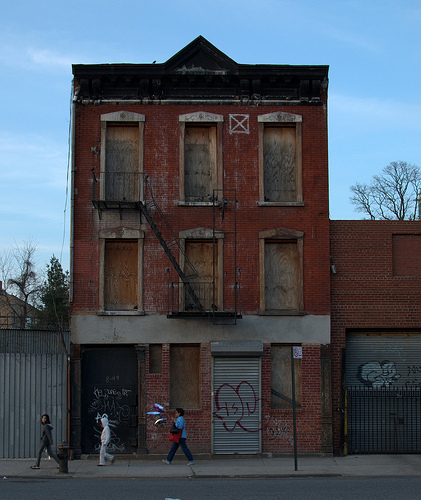

2888702775.jpg -> (500, 333)


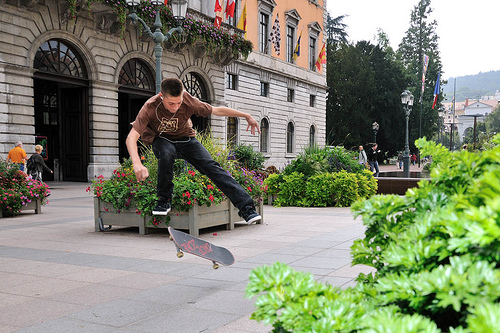

flickr30k_images\6571757523.jpg -> (498, 500)


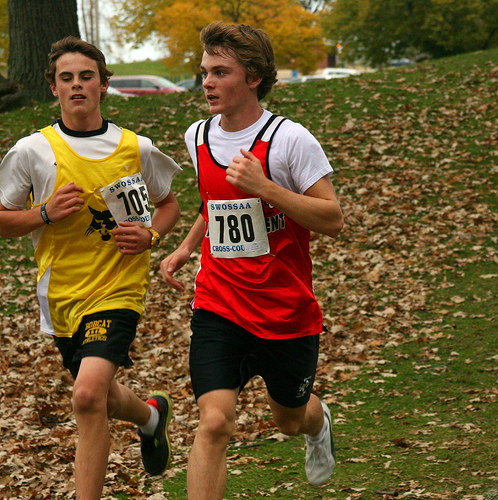

flickr30k_images\4937203156.jpg -> (500, 365)


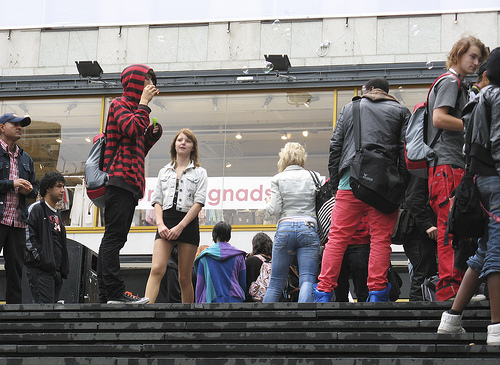

flickr30k_images\101669240.jpg -> (500, 357)


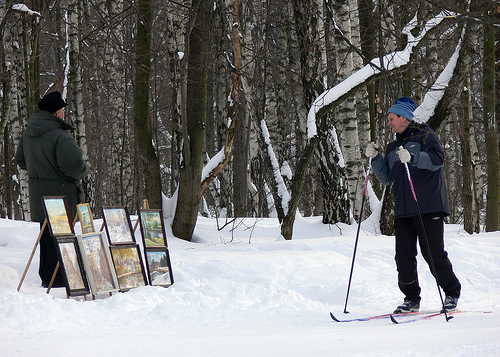

flickr30k_images\4543597515.jpg -> (500, 376)


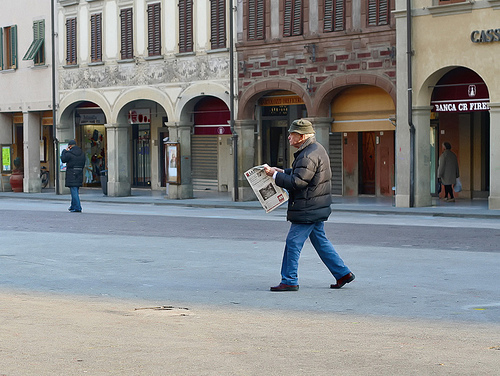

In [ ]:
# Improved visualization using `dataset_image_dir` and `image_files` prepared above
from IPython.display import display
from PIL import Image
import random
import os

# Use prepared variables from discovery cell
base_dir = globals().get('dataset_image_dir', None)
files = globals().get('image_files', [])

if base_dir is None or len(files) == 0:
    print('`dataset_image_dir` or `image_files` not prepared. Run the discovery cell first.')
else:
    num_samples = min(6, len(files))
    print(f'Displaying {num_samples} random samples from {base_dir}')
    samples = random.sample(files, num_samples)
    for f in samples:
        path = os.path.join(base_dir, f)
        try:
            im = Image.open(path)
            im.thumbnail((600, 600))
            print(f, '->', im.size)
            display(im)
        except Exception as e:
            print('Failed to open', path, e)


In [ ]:
# Quick smoke-test to instantiate the model and run a tiny forward pass (CPU, small batch)
# This verifies the small fixes above (import, PatchEmbedding param, dropout assignment, range usage).
import torch

device = torch.device('cpu')
model = CLIP(
    img_size=224,
    patch_size=16,
    vision_embed_dim=768,
    vision_depth=2,  # use small depth for quick test
    vision_heads=12,
    vocab_size=49408,
    text_embed_dim=512,
    max_len=77,
    text_heads=8,
    text_depth=2,
    output_dim=512,
    temperature=0.07,
).to(device)

# tiny batch
imgs = torch.randn(2, 3, 224, 224).to(device)
texts = torch.randint(0, 49408, (2, 77)).to(device)
logits, img_feat, txt_feat = model(imgs, texts)
print('logits', logits.shape)
print('img_feat', img_feat.shape)
print('txt_feat', txt_feat.shape)
